In [1]:
# Instalación e importación de librerías
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
import cv2

print("NumPy      :", np.__version__)
print("Pandas     :", pd.__version__)
print("PyTorch    :", torch.__version__)
import torchvision
print("TorchVision:", torchvision.__version__)


NumPy      : 2.2.6
Pandas     : 2.3.0
PyTorch    : 2.8.0+cu128
TorchVision: 0.23.0+cu128


In [ ]:
# Preprocesado Resize + CenterCrop ResNet18
transform_img = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
])
# Preprocesado from numpy array + Resize ResNet18
# Después de recotar y completar se ajusta el tamaño
# Es necesario pasar el nparray formato Image
transform_nparray = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224)
])

In [6]:
# Aquí las funciones que se utilizan para recortar y completar
def get_nrow_init(img):
    """
    Find the first non-blank row in a 3-channel image.
    
    Scans the image from the top down to find the first row that contains
    non-zero pixel values in any of the color channels.
    """
    nrow = 0
    for nrow in range(img.shape[0]):
        result = (all(img[nrow,:,0] == 0),
                  all(img[nrow,:,1] == 0),
                  all(img[nrow,:,2] == 0))
        if not all(result):
            break
    return nrow

def get_nrow_end(img):
    """
    Find the last non-blank row in a 3-channel image.
    
    Scans the image from the bottom up to find the last row that contains
    non-zero pixel values in any of the color channels.
    """
    nrow = img.shape[0]
    for nrow in reversed(range(0, img.shape[0])):
        result = (all(img[nrow,:,0] == 0),
                  all(img[nrow,:,1] == 0),
                  all(img[nrow,:,2] == 0))
        if not all(result):
            break
    return nrow

def get_ncol_init(img):
    """
    Find the first non-blank column in a 3-channel image.
    
    Scans the image from left to right to find the first column that contains
    non-zero pixel values in any of the color channels.
    """
    ncol = 0
    for ncol in range(img.shape[1]):
        result = (all(img[:,ncol,0] == 0),
                  all(img[:,ncol,1] == 0),
                  all(img[:,ncol,2] == 0))
        if not all(result):
            break
    return ncol

def get_ncol_end(img):
    """
    Find the last non-blank column in a 3-channel image.
    
    Scans the image from right to left to find the last column that contains
    non-zero pixel values in any of the color channels.
    """
    ncol = img.shape[1]
    for ncol in reversed(range(0,img.shape[1])):
        result = (all(img[:,ncol,0] == 0),
                  all(img[:,ncol,1] == 0),
                  all(img[:,ncol,2] == 0))
        if not all(result):
            break
    return ncol

def expand_image(img, nrow_init, nrow_end, ncol_init, ncol_end):
    """
    Expand an image to make it square by adding padding to the shorter dimension.
    
    Calculates the difference between height and width of the region of interest,
    then adds equal padding to both sides of the shorter dimension to create
    a square image. Padding is added as black (zero) pixels.
    """
    drow = nrow_end - nrow_init
    dcol = ncol_end - ncol_init
    d = drow - dcol
    nadd = abs(d)
    add_before = nadd//2 + nadd%2
    add_after = nadd//2
    if d > 0:
        img_expanded = np.pad(img,pad_width=((0,0),(add_before,add_after),(0,0)), mode='constant')
    elif d < 0:
        img_expanded = np.pad(img,pad_width=((add_before,add_after),(0,0),(0,0)), mode='constant')
    else:
        img_expanded = img
    return img_expanded

def square_image(img):
    """
    Crop an image to its content region and expand it to a square shape.
    """
    nrow_init = get_nrow_init(img)
    nrow_end = get_nrow_end(img)
    ncol_init = get_ncol_init(img)
    ncol_end = get_ncol_end(img)
    img_cropped = img[nrow_init:nrow_end,ncol_init:ncol_end,:]
    expanded_image = expand_image(img_cropped, nrow_init, nrow_end, ncol_init, ncol_end)
    return expanded_image

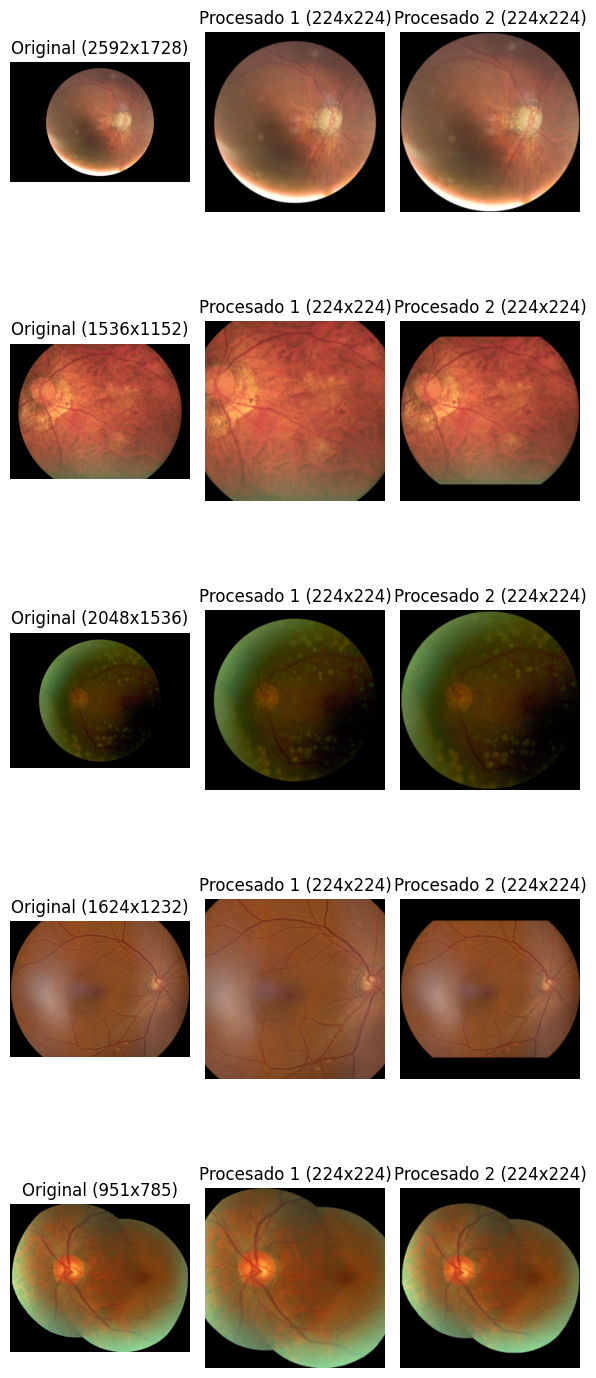

In [7]:
# Comparativa original, procesado 1 y procesado 2
images = ["167_right.jpg", "18_left.jpg", "2_left.jpg", "205_right.jpg", "854_left.jpg"]
n = len(images)
image_dir = "../ODIR-5K/ODIR-5K/Training Images"

plt.figure(figsize=(6, 3 * len(images)))
for i, fname in enumerate(images):
    
    path = os.path.join(image_dir, fname)

    # Procesado 1: Resize + CropSize
    img = Image.open(path).convert("RGB")
    img_transformed = transform_img(img)
    
    # Procesado 2: Custom Crop + Resize
    img_cv2 = cv2.imread(path)
    squared_image = square_image(img_cv2)
    img_transformed2 = transform_nparray(squared_image[:,:,::-1])

    # Original
    width, height = img.size
    plt.subplot(n, 3, 3*i + 1)
    plt.imshow(img)
    plt.title(f"Original ({width}x{height})")
    plt.axis("off")
    # Procesado 1
    width, height = img_transformed.size
    plt.subplot(n, 3, 3*i + 2)
    plt.imshow(img_transformed)
    plt.title(f"Procesado 1 ({width}x{height})")
    plt.axis("off")
    # Procesado 2
    width, height = img_transformed2.size
    plt.subplot(n, 3, 3*i + 3)
    plt.imshow(img_transformed2)
    plt.title(f"Procesado 2 ({width}x{height})")
    plt.axis("off")
    
plt.tight_layout()
plt.show()